# Data loading 
Next cells are used to load the data we need.

In [1]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')


In [5]:
#data which contains users (row), items(col) and implicit interaction (data)
dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


# Data pre-processing
Pre-processing of data to check for missing users, items ecc...

In [6]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

In [7]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

#splitting data into train and validation (from the previous training data)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)



In [8]:
#evaluator for validation (used for hyperparameter tuning)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

#evaluator for testing (the final one)
#evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [9]:
from GraphBased.P3alphaRecommender import P3alphaRecommender

recommender = P3alphaRecommender(URM_train)

P3alphaRecommender: URM Detected 37 (0.47 %) cold users.
P3alphaRecommender: URM Detected 1958 (7.54 %) cold items.


In [19]:
x_tick = []
collaborative_MAP = []

for topK in [70,90,100,110,120,130,150]:
    for alpha in [0.4,0.5,0.55,0.6]:
     

        x_tick.append("topk {}, alpha{}".format(topK,alpha))


        recommender = P3alphaRecommender(URM_train)

         #remember to specify the positive threshold
        recommender.fit(topK=topK, alpha=alpha, implicit=True)

        result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

        collaborative_MAP.append(result_dict[10]["MAP"])

P3alphaRecommender: URM Detected 38 (0.48 %) cold users.
P3alphaRecommender: URM Detected 1999 (7.70 %) cold items.
EvaluatorHoldout: Processed 4935 ( 100.00% ) in 2.90 sec. Users per second: 1704
P3alphaRecommender: URM Detected 38 (0.48 %) cold users.
P3alphaRecommender: URM Detected 1999 (7.70 %) cold items.
EvaluatorHoldout: Processed 4935 ( 100.00% ) in 2.98 sec. Users per second: 1658
P3alphaRecommender: URM Detected 38 (0.48 %) cold users.
P3alphaRecommender: URM Detected 1999 (7.70 %) cold items.
EvaluatorHoldout: Processed 4935 ( 100.00% ) in 3.08 sec. Users per second: 1605
P3alphaRecommender: URM Detected 38 (0.48 %) cold users.
P3alphaRecommender: URM Detected 1999 (7.70 %) cold items.
EvaluatorHoldout: Processed 4935 ( 100.00% ) in 2.90 sec. Users per second: 1703
P3alphaRecommender: URM Detected 38 (0.48 %) cold users.
P3alphaRecommender: URM Detected 1999 (7.70 %) cold items.
EvaluatorHoldout: Processed 4935 ( 100.00% ) in 3.01 sec. Users per second: 1637
P3alphaRecommen

In [20]:
import operator
index, value = max(enumerate(collaborative_MAP), key=operator.itemgetter(1))
print(index, value)
parameters = x_tick[index]
print(parameters)

13 0.058225970751541255
topk 110, alpha0.5


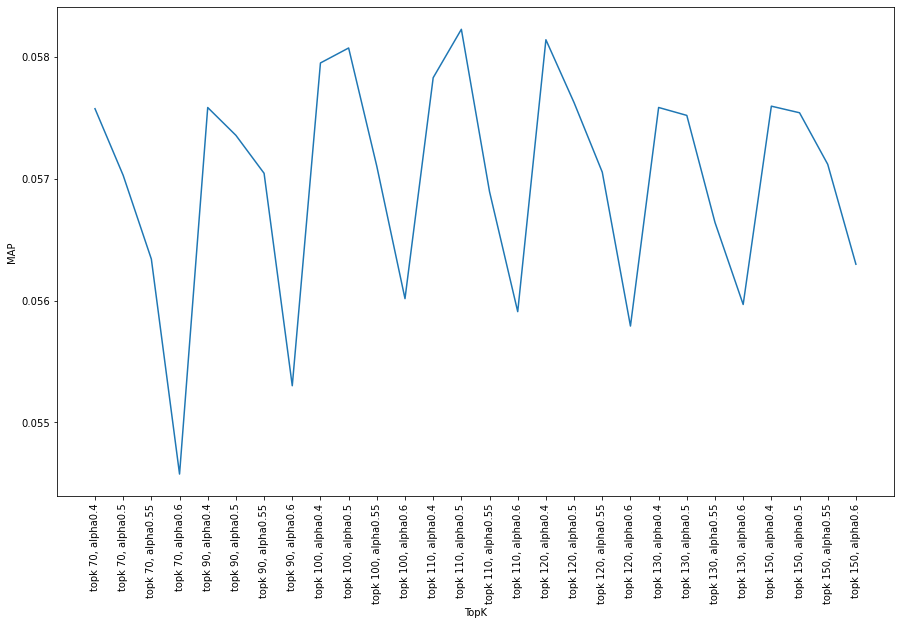

In [21]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
plt.plot(x_tick, collaborative_MAP, label="Collaborative")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.001))
plt.ylabel('MAP')
plt.xlabel('TopK')
plt.xticks(rotation='vertical')
plt.show()

In [10]:
test_users = pd.read_csv('data_target_users_test.csv')
test_users

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
7939,7942
7940,7943
7941,7944
7942,7945


In [11]:
recommender = P3alphaRecommender(URM_all)

recommender.fit(topK=200, alpha=0.5, implicit=True)

user_id = test_users['user_id']
recommendations = recommender.recommend(user_id,cutoff = 10)


P3alphaRecommender: URM Detected 1079 (4.15 %) cold items.


In [13]:
print(recommender.W_sparse.mean())

0.0002625741


In [36]:
for index in range(len(recommendations)):
    #print(element)
    recommendations[index]=np.array(recommendations[index])
    #print(type(element))
print(len(recommendations))

7944


In [37]:
test_users['item_list']= recommendations
#test_users['item_list'] =  test_users['item_list'].apply(lambda x: x.replace('[','').replace(']','')) 
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])

#convert the string columns to int
#test_users['item_list'] = test_users['item_list'].astype(int)
test_users
test_users.to_csv('submission.csv', index=False)
